# 第12組_社群媒體分析_期末專案_情緒分析

## 組別：Group 12
## 題目：PTT論壇AI相關議題的語料分析與趨勢探勘
### 使用工具：Python

M134020005 馮祐倫  
M134020051 柯昆霖

報告影片連結：https://youtu.be/NcM5DaE0uTg


## 目的
2023 年起，生成式 AI 帶來了前所未有的變革浪潮。從 ChatGPT 到 Midjourney、從人工到自動化，AI 正以前所未有的速度滲透人們的工作與生活。  
而在台灣最具代表性的網路論壇之一——PTT，鄉民們也開始熱烈討論這波浪潮帶來的機會與焦慮。

本專案計畫分析和說明以下三個核心問題：

1. PTT 社群如何看待 AI 在職場與科技工作的角色與影響？

2. 各主要實體（如：公司、技術、人物等）在討論中扮演什麼樣的網絡位置與影響力？

3. 不同主題下的情緒傾向與輿論熱點為何？


透過各種不同的分析，進一步揭示各實體在社群中的連結強度、討論中心性與潛在社群結構：

1. 情緒分析 (Sentiment Analysis)

    目的：判斷貼文中對 AI 的整體情感傾向（正向、中立、負向）。

    應用：了解網友對 AI 技術、AI 應用在工作上，以及 AI 對職場未來影響的情緒態度，並進一步探索情緒隨時間或議題的變化趨勢。

2. 主題模型分析 (Topic Modeling)

    目的：藉由 BERTopic 方法，自動挖掘貼文中的主題結構，找出幾大核心討論議題。

    應用：了解在「AI+工作」範疇內，網友最關注哪些面向（例如「AI 自動化取代工作」、「AI 招募面試應用」、「AI 技能學習建議」……），並分析每個主題的情緒分佈與實體共現情況。

3. 命名實體識別 (NER)

    目的：自動偵測並抽取貼文中的組織（ORG）、人物（PERSON）、產品（PRODUCT）、技術（TECH）等實體。

    應用：辨識出在 AI 討論中最常被提及的公司（如台積電、NVIDIA）、研究單位、意見領袖，或是關鍵技術名詞，為後續網路圖與主題建模提供實體基礎。

4. 網路圖構建 (Network Graph Analysis)

    目的：將貼文中的實體 (經由 NER) 與關鍵詞或使用者互動關係視覺化為節點與邊，構建實體共現網路或使用者互動網路。

    應用：揭示 AI 議題中各實體之間的關聯強度（例如哪些公司或技術一起被討論最多）、意見領袖的社群結構，以及不同主題或情緒社群的網絡分布。


綜合以上，能更立體地描繪出台灣論壇使用者在 AI 職場議題中的討論趨勢、關注焦點與情緒反應。


## 資料集概覽

此資料集收集自台灣的社群媒體平台 PTT。  
PTT「工作」、「職場」、「科技工作」三個版中，針對含有 “AI” 關鍵字的貼文。  
資料收集範圍從 2024 年 5 月 1 日到 2025 年 5 月 1 日，共包含 2456 筆資料。

## 資料欄位說明

資料集包含以下 10 個欄位：

1. `system_id`: 系統編號
2. `artComment`: 文章評論
3. `artDate`: 文章日期
4. `insertedDate`: 插入日期
5. `artContent`: 文章內容
6. `artCatagory`: 文章類別
7. `dataSource`: 資料來源
8. `artPoster`: 發文者
9. `artTitle`: 文章標題。
10. `artUrl`: 文章網址

### 載入套件

In [ ]:
# import package
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)

from wordcloud import WordCloud

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from pprint import pprint

FontPath = 'dict/SourceHanSansTW-Regular.otf'
# fprop = fm.FontProperties(fname="SourceHanSansTW-Regular.otf")

In [144]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Heiti TC']  # macOS 的中文系統字型
plt.rcParams['axes.unicode_minus'] = False         # 正常顯示負號

### 資料載入

In [ ]:
df = pd.read_csv("Merged.csv")
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt
1,2,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,[新聞]年後轉職最熱門公司出爐前三名台積電、,2024-05-01 17:24:04,qazxc1156892,Tech_Job,新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""abc21086999""...",223.137.1.131,2024-05-02 02:19:38,ptt
2,3,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,[新聞]訓練台版AI語言模型，許永真：盼讓百工,2024-05-01 17:48:08,pl132,Tech_Job,訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ling621"", ""c...",180.177.2.112,2024-05-02 02:19:38,ptt
3,4,https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...,[新聞]首屆台法科研會議吳政忠：六大領域可望,2024-05-01 21:41:58,createlight,Tech_Job,https://www.epochtimes.com/b5/24/4/30/n1423755...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""unima"", ""cmt...",114.39.34.219,2024-05-02 02:19:38,ptt
4,5,https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...,[心得]電子業PM面試紀錄（長文）,2024-05-01 21:43:46,tin8420,Tech_Job,https://reurl.cc/ezOm9x\n網誌版\n\n商科學士29y，傳產PM+生...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KMTlikesshit...",118.231.160.114,2024-05-02 02:19:38,ptt


In [146]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head()

,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。。前陣子業界很凍（現在好像也.....
1,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,[新聞]年後轉職最熱門公司出爐前三名台積電、,2024-05-01 17:24:04,qazxc1156892,Tech_Job,新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""abc21086999""...",223.137.1.131,2024-05-02 02:19:38,ptt,新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電。2024-05-01 11:...
2,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,[新聞]訓練台版AI語言模型，許永真：盼讓百工,2024-05-01 17:48:08,pl132,Tech_Job,訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ling621"", ""c...",180.177.2.112,2024-05-02 02:19:38,ptt,訓練台版 AI 語言模型，許永真：盼讓百工百業商用 4 月啟動 TAIDE 計畫，研發台版大...
3,https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...,[新聞]首屆台法科研會議吳政忠：六大領域可望,2024-05-01 21:41:58,createlight,Tech_Job,https://www.epochtimes.com/b5/24/4/30/n1423755...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""unima"", ""cmt...",114.39.34.219,2024-05-02 02:19:38,ptt,吳政忠：六大領域可望締造雙贏 Giry）。（國科會提供）。【大紀元2024年04月30日訊...
4,https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...,[心得]電子業PM面試紀錄（長文）,2024-05-01 21:43:46,tin8420,Tech_Job,https://reurl.cc/ezOm9x\n網誌版\n\n商科學士29y，傳產PM+生...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KMTlikesshit...",118.231.160.114,2024-05-02 02:19:38,ptt,威剛 — Sales PM面試地點在中和，結果搞小烏龍跑錯棟+樓層，有稍微遲到一下下，感覺...


## 1.0 資料清理

### 1.1 斷句

In [147]:
# 先移除空白或 NaN 的欄位
clear_df = clear_df.dropna(subset=['sentence'])
clear_df = clear_df[clear_df['sentence'].str.strip() != '']

# 再做斷句
clear_df['sentence'] = clear_df['sentence'].str.split(r"[,，。！!？?]+")

# 展開為每句一列
sent_df = clear_df.explode('sentence').reset_index(drop=True)

# 去除斷句後的空字串（有時可能會分出空句）
sent_df = sent_df[sent_df['sentence'].str.strip() != '']

sent_df.head()


,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,很明顯絕對會
1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,我之前面試時就遇過
2,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,而且明擺著開太高不會用你
3,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,前陣子業界很凍（現在好像也...）
4,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,我又剛好快畢業了整個人充滿求職焦慮所以104上只要我覺得可以做的工作就投不管那家公司在哪叫什...


### 1.2 斷詞

In [148]:
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/stop_words.txt')

Building prefix dict from /Users/kunlin/Documents/NSYSU_中山大學/113-2 課程/MIS581_社群媒體分析/期末專案/dict/dict.txt ...
Loading model from cache /var/folders/jl/rs16gbqd5bz6g1r6y4xjtp480000gn/T/jieba.u4a927e526febc3de6ec7274c5bfb7a24.cache
Loading model cost 0.166 seconds.
Prefix dict has been built successfully.


In [149]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head()

,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,很明顯絕對會
1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,我之前面試時就遇過
2,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,而且明擺著開太高不會用你
3,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,前陣子業界很凍現在好像也
4,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,我又剛好快畢業了整個人充滿求職焦慮所以104上只要我覺得可以做的工作就投不管那家公司在哪叫什...


In [150]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head()

,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,word
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,明顯
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,絕對
1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,之前
1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,面試
1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,遇過


In [151]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stop_words.txt', 'r', encoding='utf-8').readlines()] 
# stopwords.extend(stopwords_manual)

In [152]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head()

,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,word
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,明顯
1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,之前
1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,面試
1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,遇過
2,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt,明擺


## 2.0 Lexicon-Based 情緒分析

### 2.1 LIWC字典

In [153]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/LIWC/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


### 2.2 標記 Sentiments

In [154]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,2024-05-01 16:50:30,Re:[面試]104待遇寫4w~4.8w你應該開多少？,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,明顯,NaN
1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,2024-05-01 16:50:30,Re:[面試]104待遇寫4w~4.8w你應該開多少？,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,之前,NaN
2,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,2024-05-01 16:50:30,Re:[面試]104待遇寫4w~4.8w你應該開多少？,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,面試,NaN
3,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,2024-05-01 16:50:30,Re:[面試]104待遇寫4w~4.8w你應該開多少？,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,遇過,NaN
4,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,2024-05-01 16:50:30,Re:[面試]104待遇寫4w~4.8w你應該開多少？,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,明擺,NaN


In [155]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_count.head(10)

,word,sentiments,size
1125,智慧,positive,1082
1124,智慧,affect,1082
377,同意,positive,1054
376,同意,affect,1054
1596,禁止,affect,1032
1597,禁止,anx,1032
1598,禁止,negative,1032
1468,獎金,affect,995
1469,獎金,positive,995
1735,自負,affect,984


In [156]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
1125,智慧,positive,1082
377,同意,positive,1054
1469,獎金,positive,995
301,協助,positive,961
1600,福利,positive,663
1979,重要,positive,473
660,希望,positive,469
1807,解決,positive,464
1609,積極,positive,461
586,安全,positive,339


智慧是智慧製造嗎 好好笑

In [157]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
1598,禁止,negative,1032
1736,自負,negative,984
416,問題,negative,929
1230,歧視,negative,497
1955,違法,negative,342
2054,風險,negative,190
499,壓力,negative,128
2008,降低,negative,117
1059,擔心,negative,106
455,嚴重,negative,100


### 2.3 移除錯誤情緒字

In [158]:
# 設定要移除的字詞列表
words_to_remove = ['面試','重要','同意']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,2024-05-01 16:50:30,Re:[面試]104待遇寫4w~4.8w你應該開多少？,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,明顯,NaN
1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,2024-05-01 16:50:30,Re:[面試]104待遇寫4w~4.8w你應該開多少？,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,之前,NaN
2,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,2024-05-01 16:50:30,Re:[面試]104待遇寫4w~4.8w你應該開多少？,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,面試,NaN
3,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,2024-05-01 16:50:30,Re:[面試]104待遇寫4w~4.8w你應該開多少？,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,遇過,NaN
4,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,2024-05-01 16:50:30,Re:[面試]104待遇寫4w~4.8w你應該開多少？,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,明擺,NaN


### 2.4 計算sentiment-value
sentiment-value = positive - negative

In [159]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)

#正負向情緒分數
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# 計算sentiment
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2024-05-01 10:57:40,4.0,3.0,-1.0
1,2024-05-01 16:50:30,3.0,2.0,-1.0
2,2024-05-01 17:24:04,2.0,9.0,7.0
3,2024-05-01 17:48:08,7.0,14.0,7.0
4,2024-05-01 21:41:58,0.0,2.0,2.0


### 2.5 文章情緒分析

In [160]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article.head(10)

,artUrl,sentiments,size
0,https://www.ptt.cc/bbs/Salary/M.1714625405.A.F...,affect,1
1,https://www.ptt.cc/bbs/Salary/M.1714625405.A.F...,negative,1
2,https://www.ptt.cc/bbs/Salary/M.1714625405.A.F...,sad,1
3,https://www.ptt.cc/bbs/Salary/M.1714640886.A.6...,affect,12
4,https://www.ptt.cc/bbs/Salary/M.1714640886.A.6...,negative,2
5,https://www.ptt.cc/bbs/Salary/M.1714640886.A.6...,positive,10
6,https://www.ptt.cc/bbs/Salary/M.1714727149.A.0...,affect,8
7,https://www.ptt.cc/bbs/Salary/M.1714727149.A.0...,positive,8
8,https://www.ptt.cc/bbs/Salary/M.1715004346.A.A...,affect,2
9,https://www.ptt.cc/bbs/Salary/M.1715004346.A.A...,positive,2


In [161]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.ptt.cc/bbs/Salary/M.1714625405.A.F...,1.0,0.0,0.0,1.0,0.0,1.0
1,https://www.ptt.cc/bbs/Salary/M.1714640886.A.6...,12.0,0.0,0.0,2.0,10.0,0.0
2,https://www.ptt.cc/bbs/Salary/M.1714727149.A.0...,8.0,0.0,0.0,0.0,8.0,0.0
3,https://www.ptt.cc/bbs/Salary/M.1715004346.A.A...,2.0,0.0,0.0,0.0,2.0,0.0
4,https://www.ptt.cc/bbs/Salary/M.1715850371.A.1...,8.0,0.0,0.0,2.0,6.0,1.0


### 2.6 每個文章的 sentiment value

In [162]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/Salary/M.1714625405.A.F...,1.0,0.0,0.0,1.0,0.0,1.0,-1.0
1,https://www.ptt.cc/bbs/Salary/M.1714640886.A.6...,12.0,0.0,0.0,2.0,10.0,0.0,8.0
2,https://www.ptt.cc/bbs/Salary/M.1714727149.A.0...,8.0,0.0,0.0,0.0,8.0,0.0,8.0
3,https://www.ptt.cc/bbs/Salary/M.1715004346.A.A...,2.0,0.0,0.0,0.0,2.0,0.0,2.0
4,https://www.ptt.cc/bbs/Salary/M.1715850371.A.1...,8.0,0.0,0.0,2.0,6.0,1.0,4.0


### 2.7 劃分文章的 sentiment class

In [163]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article.head(10)

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/Salary/M.1714625405.A.F...,1.0,0.0,0.0,1.0,0.0,1.0,-1.0,負向
1,https://www.ptt.cc/bbs/Salary/M.1714640886.A.6...,12.0,0.0,0.0,2.0,10.0,0.0,8.0,正向
2,https://www.ptt.cc/bbs/Salary/M.1714727149.A.0...,8.0,0.0,0.0,0.0,8.0,0.0,8.0,正向
3,https://www.ptt.cc/bbs/Salary/M.1715004346.A.A...,2.0,0.0,0.0,0.0,2.0,0.0,2.0,正向
4,https://www.ptt.cc/bbs/Salary/M.1715850371.A.1...,8.0,0.0,0.0,2.0,6.0,1.0,4.0,正向
5,https://www.ptt.cc/bbs/Salary/M.1716043240.A.4...,8.0,0.0,0.0,1.0,6.0,0.0,5.0,正向
6,https://www.ptt.cc/bbs/Salary/M.1716174047.A.9...,5.0,0.0,1.0,2.0,3.0,0.0,1.0,正向
7,https://www.ptt.cc/bbs/Salary/M.1716265626.A.4...,14.0,4.0,2.0,7.0,7.0,0.0,0.0,負向
8,https://www.ptt.cc/bbs/Salary/M.1716461824.A.8...,16.0,0.0,1.0,3.0,10.0,2.0,7.0,正向
9,https://www.ptt.cc/bbs/Salary/M.1717413765.A.8...,5.0,0.0,0.0,0.0,5.0,0.0,5.0,正向


### 2.8 情緒分析結果儲存

In [164]:
# 合併文章情緒結果回原始文章表（用 artUrl 對應）
final_df = pd.merge(
    df,
    ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']],
    on='artUrl',
    how='left'
)

# 選擇要輸出的欄位
final_output = final_df[['artUrl', 'artTitle', 'artDate', 'artContent', 'artCatagory', 'sentiment_class']]
final_output


,artUrl,artTitle,artDate,artContent,artCatagory,sentiment_class
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,Tech_Job,負向
1,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,[新聞]年後轉職最熱門公司出爐前三名台積電、,2024-05-01 17:24:04,新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...,Tech_Job,正向
2,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,[新聞]訓練台版AI語言模型，許永真：盼讓百工,2024-05-01 17:48:08,訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...,Tech_Job,正向
3,https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...,[新聞]首屆台法科研會議吳政忠：六大領域可望,2024-05-01 21:41:58,https://www.epochtimes.com/b5/24/4/30/n1423755...,Tech_Job,正向
4,https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...,[心得]電子業PM面試紀錄（長文）,2024-05-01 21:43:46,https://reurl.cc/ezOm9x\n網誌版\n\n商科學士29y，傳產PM+生...,Tech_Job,正向
...,...,...,...,...,...,...
2452,https://www.ptt.cc/bbs/job/M.1745987945.A.CF3....,[台北]台灣防止虐待動物協會/調查員,2025-04-30 12:39:03,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job,正向
2453,https://www.ptt.cc/bbs/job/M.1745994632.A.3EF....,[台北][桃園]中壢工業區汽車展示廠日班保全,2025-04-30 14:30:30,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job,負向
2454,https://www.ptt.cc/bbs/job/M.1745994872.A.AF0....,[台北/派遣]台灣期貨交易所徵學生實習行政,2025-04-30 14:34:28,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job,負向
2455,https://www.ptt.cc/bbs/job/M.1745999676.A.98A....,[台北],2025-04-30 15:54:33,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job,負向


In [165]:
final_output = final_output.dropna(subset=['sentiment_class'])
final_output

,artUrl,artTitle,artDate,artContent,artCatagory,sentiment_class
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,Tech_Job,負向
1,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,[新聞]年後轉職最熱門公司出爐前三名台積電、,2024-05-01 17:24:04,新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...,Tech_Job,正向
2,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,[新聞]訓練台版AI語言模型，許永真：盼讓百工,2024-05-01 17:48:08,訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...,Tech_Job,正向
3,https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...,[新聞]首屆台法科研會議吳政忠：六大領域可望,2024-05-01 21:41:58,https://www.epochtimes.com/b5/24/4/30/n1423755...,Tech_Job,正向
4,https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...,[心得]電子業PM面試紀錄（長文）,2024-05-01 21:43:46,https://reurl.cc/ezOm9x\n網誌版\n\n商科學士29y，傳產PM+生...,Tech_Job,正向
...,...,...,...,...,...,...
2452,https://www.ptt.cc/bbs/job/M.1745987945.A.CF3....,[台北]台灣防止虐待動物協會/調查員,2025-04-30 12:39:03,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job,正向
2453,https://www.ptt.cc/bbs/job/M.1745994632.A.3EF....,[台北][桃園]中壢工業區汽車展示廠日班保全,2025-04-30 14:30:30,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job,負向
2454,https://www.ptt.cc/bbs/job/M.1745994872.A.AF0....,[台北/派遣]台灣期貨交易所徵學生實習行政,2025-04-30 14:34:28,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job,負向
2455,https://www.ptt.cc/bbs/job/M.1745999676.A.98A....,[台北],2025-04-30 15:54:33,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,job,負向


In [166]:
final_output.to_csv("ptt_ai_sentiment.csv", index=False, encoding='utf-8-sig')
print("✅ 已儲存完整檔案：ptt_ai_sentiment.csv")

✅ 已儲存完整檔案：ptt_ai_sentiment.csv


## 3.0 情緒文件分類

### 3.1 資料清理

In [167]:
ai = pd.read_csv("ptt_ai_sentiment.csv") # 匯資料
ai.head(3)

,artUrl,artTitle,artDate,artContent,artCatagory,sentiment_class
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,Tech_Job,負向
1,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,[新聞]年後轉職最熱門公司出爐前三名台積電、,2024-05-01 17:24:04,新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...,Tech_Job,正向
2,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,[新聞]訓練台版AI語言模型，許永真：盼讓百工,2024-05-01 17:48:08,訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...,Tech_Job,正向


In [168]:
print(f"number of posts: {ai.shape[0]}")
print(f"date range: {(ai['artDate'].min(), ai['artDate'].max())}")
print(f"category: \n{ai['sentiment_class'].value_counts()}")

number of posts: 2347
date range: ('2024-05-01 10:57:40', '2025-05-01 19:53:45')
category: 
sentiment_class
正向    1648
負向     699
Name: count, dtype: int64


In [169]:
# 過濾 nan 的資料
ai = ai.dropna(subset=['artTitle'])
ai = ai.dropna(subset=['artContent'])
# 移除網址格式
ai["artContent"] = ai.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
ai["artTitle"] = ai["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
ai["artContent"] = ai.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ai["artTitle"] = ai["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ai.head(3)

,artUrl,artTitle,artDate,artContent,artCatagory,sentiment_class
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,面試待遇寫你應該開多少,2024-05-01 16:50:30,很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現在好像也我又剛好快畢業...,Tech_Job,負向
1,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,新聞年後轉職最熱門公司出爐前三名台積電,2024-05-01 17:24:04,新聞標題年後轉職最熱門公司出爐前三名台積電華碩台達電經濟日報記者葉卉軒台北即時報導年後轉職潮...,Tech_Job,正向
2,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,新聞訓練台版語言模型許永真盼讓百工,2024-05-01 17:48:08,訓練台版語言模型許永真盼讓百工百業商用國科會去年月啟動計畫研發台版大型繁中語言模型台大資工系...,Tech_Job,正向


In [170]:
# 文章標題`artTitle`和內文`sentence`合併成新的`content`欄位
ai["content"] = ai["artTitle"] + ai["artContent"]
ai = ai[["content", "artUrl", "sentiment_class"]]  # 文章內容 文章連結
ai.head()

,content,artUrl,sentiment_class
0,面試待遇寫你應該開多少很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現...,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,負向
1,新聞年後轉職最熱門公司出爐前三名台積電新聞標題年後轉職最熱門公司出爐前三名台積電華碩台達電經...,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,正向
2,新聞訓練台版語言模型許永真盼讓百工訓練台版語言模型許永真盼讓百工百業商用國科會去年月啟動計畫...,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,正向
3,新聞首屆台法科研會議吳政忠六大領域可望首屆台法科研會議吳政忠六大領域可望締造雙贏圖左起國科會...,https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...,正向
4,心得電子業面試紀錄長文網誌版商科學士傳產生管年多益金色前份半路出家去寫程式資訊業不太適應就回...,https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...,正向


In [171]:
print(f"total docs: {ai.shape[0]}")

total docs: 2347


### 3.2 斷詞

In [172]:
# 設定繁體中文詞庫
jieba.set_dictionary("dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [173]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [174]:
ai["words"] = ai["content"].apply(getToken).map(" ".join)
ai.head()

Building prefix dict from /Users/kunlin/Documents/NSYSU_中山大學/113-2 課程/MIS581_社群媒體分析/期末專案/dict/dict.txt.big ...
Loading model from cache /var/folders/jl/rs16gbqd5bz6g1r6y4xjtp480000gn/T/jieba.ued0918e487b7bbaf03783db14d036714.cache
Loading model cost 0.514 seconds.
Prefix dict has been built successfully.


,content,artUrl,sentiment_class,words
0,面試待遇寫你應該開多少很明顯絕對會我之前面試時就遇過而且明擺著開太高不會用你前陣子業界很凍現...,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,負向,面試 待遇 應該 明顯 之前 面試 遇過 明擺 著開 太高 陣子 業界 很凍 現在 好像 畢...
1,新聞年後轉職最熱門公司出爐前三名台積電新聞標題年後轉職最熱門公司出爐前三名台積電華碩台達電經...,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,正向,新聞 轉職 熱門 公司 出爐 前三名 台積電 新聞標題 轉職 熱門 公司 出爐 前三名 台積...
2,新聞訓練台版語言模型許永真盼讓百工訓練台版語言模型許永真盼讓百工百業商用國科會去年月啟動計畫...,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,正向,新聞 訓練 台版 語言 模型 許永真 百工 訓練 台版 語言 模型 許永真 百工 百業 商用...
3,新聞首屆台法科研會議吳政忠六大領域可望首屆台法科研會議吳政忠六大領域可望締造雙贏圖左起國科會...,https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...,正向,新聞 首屆 台法 科研 會議 吳政忠 六大 領域 可望 首屆 台法 科研 會議 吳政忠 六大...
4,心得電子業面試紀錄長文網誌版商科學士傳產生管年多益金色前份半路出家去寫程式資訊業不太適應就回...,https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...,正向,心得 電子業 面試 紀錄 長文 網誌 商科 學士 產生 管年 多益 金色 前份 半路出家 程...


In [175]:
print(f"total posts: {len(ai['artUrl'].unique())}")
print(f"category: \n{ai['sentiment_class'].value_counts()}")

total posts: 2347
category: 
sentiment_class
正向    1648
負向     699
Name: count, dtype: int64


### 3.3 分類模型訓練

In [176]:
data = ai
X = data["words"]
y = data["sentiment_class"]

# 把整個資料集八二切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777
)

print(X_train.head())
print(y_train.head())

647     討論 機器人 透過 強化 學習 訓練 強化 學習 遊戲 取得成功 原因 遊戲 世界 虛擬 環...
2335    台北 團購 公司 誠徵 會計人員 禁止 張貼 違反 就業 服務 性別 平等 工作 勞基法 法...
436     新聞 糟近 三個 每日 退貨 超過 銷有 糟近 三個 每日 退貨 超過 銷量 新創 公司 打...
197     新聞 仁勳 台灣 重要 國家 陸媒 點名 作者 標題新聞 仁勳 台灣 重要 國家 陸媒 點名...
480     新聞 全球 晶圓 代工 市占率 出爐 台積電 全球 晶圓 代工 市占率 出爐 台積電 霸主 ...
Name: words, dtype: object
647     正向
2335    正向
436     負向
197     負向
480     負向
Name: sentiment_class, dtype: object


In [177]:
print(
    f"raw data percentage :\n{data['sentiment_class'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
sentiment_class
正向    70.217299
負向    29.782701
Name: proportion, dtype: float64

train percentage :
sentiment_class
正向    70.165157
負向    29.834843
Name: proportion, dtype: float64

test percentage :
sentiment_class
正向    70.425532
負向    29.574468
Name: proportion, dtype: float64


### 3.4 將文章轉成DTM

In [178]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [179]:
X_train.head()

647     討論 機器人 透過 強化 學習 訓練 強化 學習 遊戲 取得成功 原因 遊戲 世界 虛擬 環...
2335    台北 團購 公司 誠徵 會計人員 禁止 張貼 違反 就業 服務 性別 平等 工作 勞基法 法...
436     新聞 糟近 三個 每日 退貨 超過 銷有 糟近 三個 每日 退貨 超過 銷量 新創 公司 打...
197     新聞 仁勳 台灣 重要 國家 陸媒 點名 作者 標題新聞 仁勳 台灣 重要 國家 陸媒 點名...
480     新聞 全球 晶圓 代工 市占率 出爐 台積電 全球 晶圓 代工 市占率 出爐 台積電 霸主 ...
Name: words, dtype: object

In [180]:
vec_train = vectorizer.fit_transform(X_train)
# fit：掃描整個 X_train，建立詞彙表（vocabulary）
# transform：把每篇文件轉成詞頻向量（即每個詞在文件中出現的次數）
vocabulary = vectorizer.get_feature_names_out()

Count_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
Count_df

,一下,一些,一份,一位,一個月,一名,一天,一定,一家,一年,...,馬斯克,驗證,高度,高通,高達,高階,高雄,魏哲家,鴻海,黨派
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1873,1,7,0,0,0,0,2,2,0,0,...,0,0,0,0,0,1,0,0,0,0
1874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [181]:
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(1877, 1000)
(470, 1000)


In [182]:
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [183]:
clf.classes_

array(['正向', '負向'], dtype=object)

### 3.5 訓練模型

In [184]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['負向' '負向' '正向' '負向' '負向' '負向' '負向' '正向' '正向' '正向']


In [185]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(470, 2)


array([0.48471915, 0.51528085])

結果顯示有 470 筆預測，每筆都會有對「類別1-2」的預測機率。

In [186]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          正向       0.85      0.89      0.87       331
          負向       0.70      0.62      0.66       139

    accuracy                           0.81       470
   macro avg       0.78      0.75      0.76       470
weighted avg       0.81      0.81      0.81       470



## 4.0 TF-IDF 訓練分類模型

### 4.1 計算

In [187]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vocabulary = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(columns = vocabulary, data = vec_train.toarray())
tfidf_df

,一下,一些,一份,一位,一個月,一名,一天,一定,一家,一年,...,馬斯克,驗證,高度,高通,高達,高階,高雄,魏哲家,鴻海,黨派
0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.170371,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,0.000000,0.000000,0.0,0.158196,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.097358,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.103471,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
1873,0.022002,0.127632,0.0,0.000000,0.0,0.0,0.047018,0.037622,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.021355,0.0,0.0,0.0,0.000000
1874,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
1875,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


### 4.2 結果與評估

In [188]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          正向       0.80      0.97      0.88       331
          負向       0.86      0.42      0.57       139

    accuracy                           0.81       470
   macro avg       0.83      0.70      0.72       470
weighted avg       0.82      0.81      0.79       470



在預測 PTT 貼文情緒時，對正向內容的辨識效果非常好（召回率 0.97），但對負向情緒的偵測能力不足（recall 0.42），導致情緒分類在負向文章上的表現較弱（f1-score 0.57）。   
整體準確率為 81%，但存在明顯的類別不平衡(Class imbalance)問題，所以可能導致訓練結果不太理想。

### 4.3 Cross-Validation

In [189]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.00608206, 0.00590515, 0.00559878, 0.00575113, 0.00506282]),
 'score_time': array([0.00375414, 0.00368094, 0.00355005, 0.00360394, 0.003613  ]),
 'test_f1_macro': array([0.74158076, 0.75957859, 0.64719466, 0.73152921, 0.66931217]),
 'test_precision_macro': array([0.84374322, 0.87243579, 0.76341351, 0.83875392, 0.77769231]),
 'test_recall_macro': array([0.714421  , 0.72903139, 0.63533745, 0.70544202, 0.6531946 ])}


In [190]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          正向       0.79      0.97      0.87      1317
          負向       0.85      0.41      0.55       560

    accuracy                           0.80      1877
   macro avg       0.82      0.69      0.71      1877
weighted avg       0.81      0.80      0.78      1877



## 5.0 比較不同的 ML 模型

### 5.1 使用不同的模型

- LogisticRegression
- Random Forest
- Decision Tree
- SVM

In [191]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf),
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

### 測試

              precision    recall  f1-score   support

          正向       0.79      0.97      0.87      1317
          負向       0.85      0.41      0.55       560

    accuracy                           0.80      1877
   macro avg       0.82      0.69      0.71      1877
weighted avg       0.81      0.80      0.78      1877



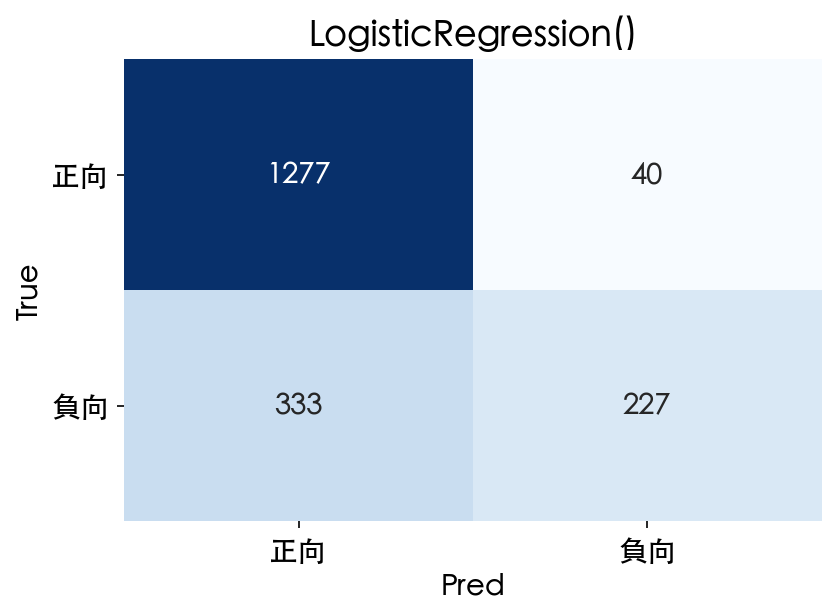

In [192]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

### 5.2 結果

now training: clf_logistic
              precision    recall  f1-score   support

          正向       0.79      0.97      0.87      1317
          負向       0.85      0.41      0.55       560

    accuracy                           0.80      1877
   macro avg       0.82      0.69      0.71      1877
weighted avg       0.81      0.80      0.78      1877

now training: clf_dtree
              precision    recall  f1-score   support

          正向       0.82      0.81      0.81      1317
          負向       0.56      0.57      0.56       560

    accuracy                           0.74      1877
   macro avg       0.69      0.69      0.69      1877
weighted avg       0.74      0.74      0.74      1877

now training: clf_svm
              precision    recall  f1-score   support

          正向       0.80      0.97      0.88      1317
          負向       0.88      0.44      0.58       560

    accuracy                           0.81      1877
   macro avg       0.84      0.71      0.73      1877
w

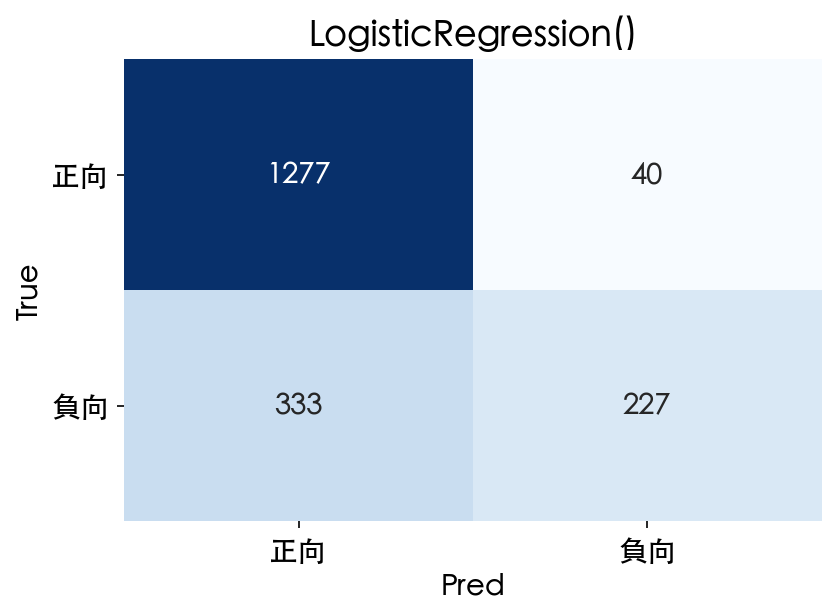

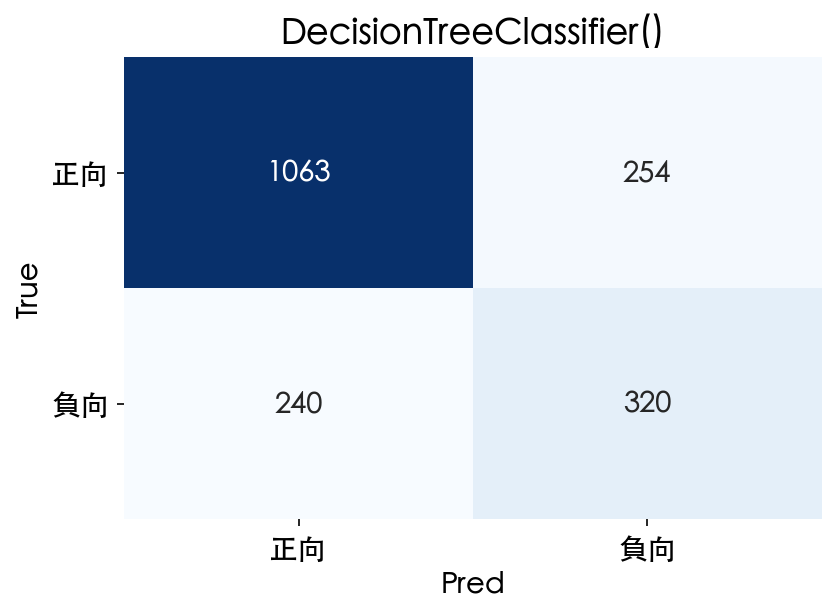

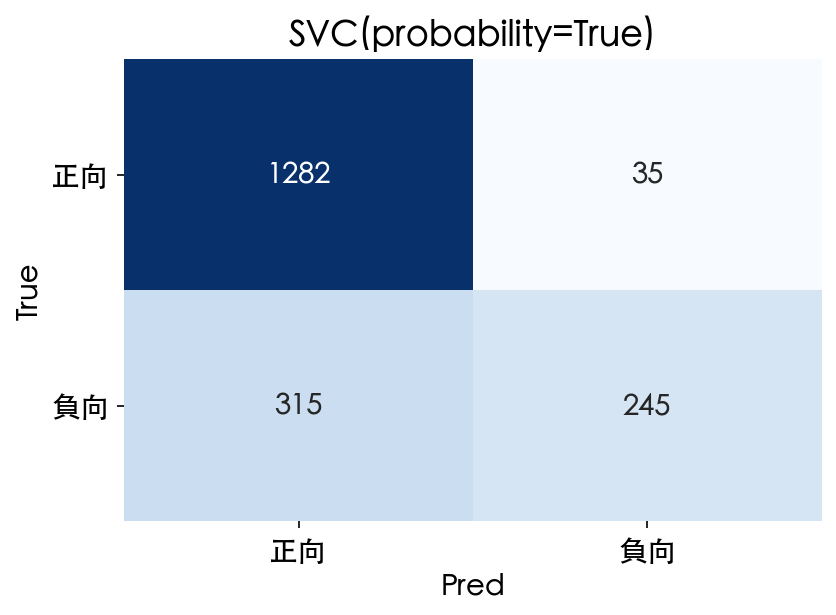

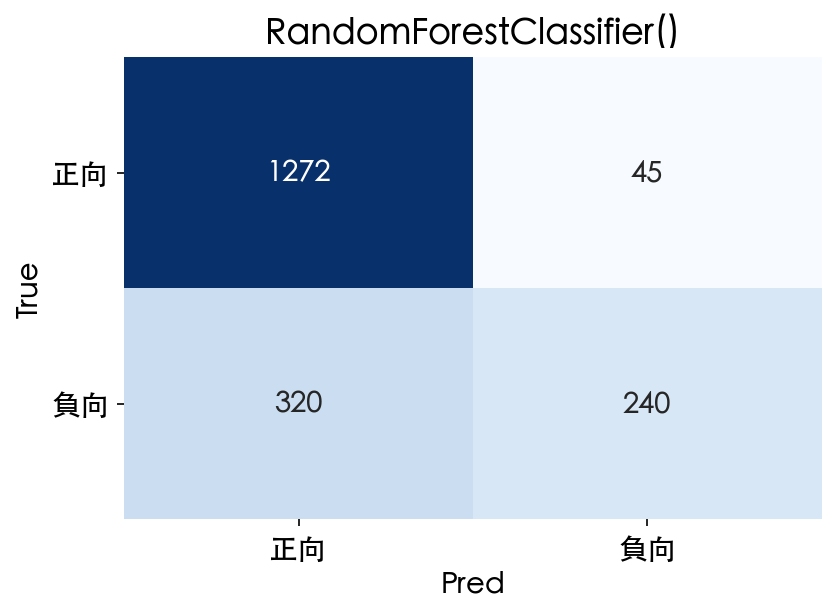

In [193]:
# 準備訓練資料
X = data["words"]
y = data["sentiment_class"]

# 把整個資料集八二切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


### 測試結果分析

In [194]:
result_set['clf_logistic']

{'正向': {'precision': 0.7931677018633541,
  'recall': 0.9696279422930904,
  'f1-score': 0.8725657669969252,
  'support': 1317.0},
 '負向': {'precision': 0.850187265917603,
  'recall': 0.40535714285714286,
  'f1-score': 0.5489721886336155,
  'support': 560.0},
 'accuracy': 0.8012786361214704,
 'macro avg': {'precision': 0.8216774838904786,
  'recall': 0.6874925425751166,
  'f1-score': 0.7107689778152704,
  'support': 1877.0},
 'weighted avg': {'precision': 0.8101793991837479,
  'recall': 0.8012786361214704,
  'f1-score': 0.7760221314703118,
  'support': 1877.0}}

### 依照 綜合評估之 F1-score 查看

In [195]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_svm
{'accuracy': 0.813532232285562,
 'macro avg': {'f1-score': 0.7316117593228094,
               'precision': 0.8388775829680651,
               'recall': 0.705462224753227,
               'support': 1877.0},
 'weighted avg': {'f1-score': 0.7914129146099876,
                  'precision': 0.8243092986349939,
                  'recall': 0.813532232285562,
                  'support': 1877.0},
 '正向': {'f1-score': 0.8798901853122855,
        'precision': 0.8027551659361303,
        'recall': 0.973424449506454,
        'support': 1317.0},
 '負向': {'f1-score': 0.5833333333333334,
        'precision': 0.875,
        'recall': 0.4375,
        'support': 560.0}}


In [196]:
y_pred = model_set['clf_svm'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          正向       0.79      0.95      0.87       331
          負向       0.79      0.40      0.53       139

    accuracy                           0.79       470
   macro avg       0.79      0.68      0.70       470
weighted avg       0.79      0.79      0.77       470



## 6.0 分析可解釋模型的結果

### 6.1 迴歸係數

In [197]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Heiti TC']  # macOS 的中文系統字型
plt.rcParams['axes.unicode_minus'] = False         # 正常顯示負號

In [198]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 二元分類只會有一列係數
    log_odds = logistic_reg_model.coef_[0]

    # 建立 DataFrame
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coefficient": log_odds
    }).set_index("feature")

    # 挑出正向與負向最具代表性的詞
    select_words = pd.concat([
        coef_df.sort_values(by="coefficient", ascending=False).head(top_n),
        coef_df.sort_values(by="coefficient", ascending=True).head(top_n)
    ])

    # 畫圖
    select_words.sort_values("coefficient").plot(
        kind="barh", figsize=(10, 6), legend=False,
        title="Top Features by Logistic Coefficient"
    )


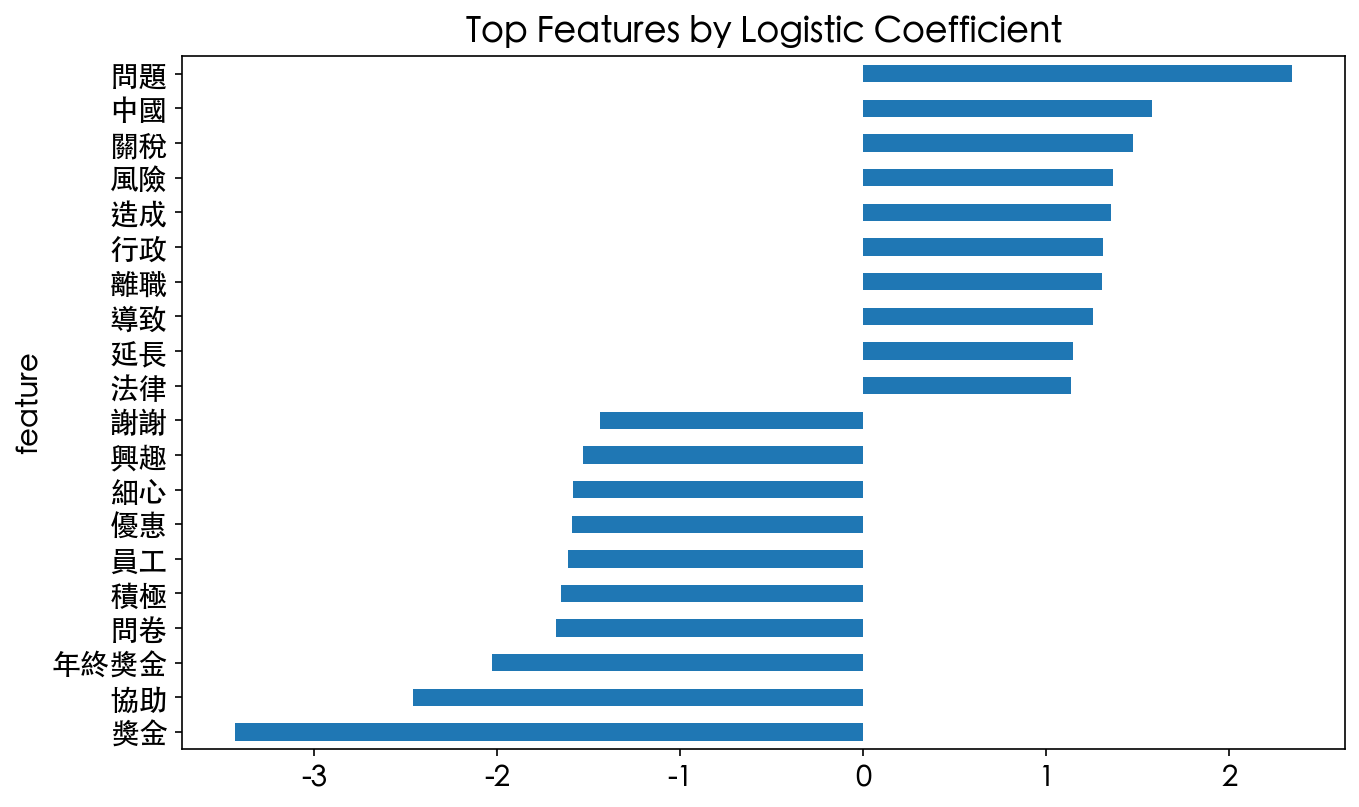

In [199]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)

我們分析了 Logistic Regression 模型中的特徵係數。係數正向表示傾向「負向情緒」，負向則表示傾向「正向情緒」。

我們可以看到模型對「年終」、「獎金」這類福利字眼給予高負係數，代表它們在正向貼文中出現機率高。

相反地，「問題」、「稅」、「法律」、「離職」這些則容易出現在抱怨文中，因此是負向情緒的指標。